In [1]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
# Activate auto reload 
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
    
from pyccapt.calibration.data_tools import data_loadcrop
from pyccapt.calibration.data_tools import raw_data_surface_concept
from pyccapt.calibration.calibration.mc_plot import AptHistPlotter
from pyccapt.calibration.data_tools.data_loadcrop import plot_crop_fdm
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.reconstructions import sdm, rdf

In [2]:
path = 'D:/pyccapt/tests/data/physics_experiment/raw_data_204_Feb-01-2024_11-51_Constant_power_'
filename = path + '/data_204_Feb-01-2024_11-51_Constant_power_W.h5'
raw_filename = path + '/data_204_Feb-01-2024_11-51_Constant_power_W_raw_ns.txt'
processed_filename = path + '/data_204_Feb-01-2024_11-51_Constant_power_W.txt'
# filename = 'D:/pyccapt/tests/data/1891_Jul-05-2024_12-10_Al_test_50um_1.h5'
# filename = 'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/data_1642_Aug-30-2023_16-05_Al_test4.h5'
df_dld = data_loadcrop.fetch_dataset_from_dld_grp(filename, extract_mode='dld')

{'apt': ['high_voltage', 'num_events', 'time_counter'], 'dld': ['high_voltage', 'pulse', 'start_counter', 't', 'x', 'y'], 'tdc': ['ch0', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7'], 'time': ['time_h', 'time_m', 'time_s']}


In [3]:
df_dld

,high_voltage (V),pulse,start_counter,t (ns),x_det (cm),y_det (cm)
0,0.000000,0.000000e+00,0,0.0000,0.000000,0.000000
1,0.000000,0.000000e+00,1,0.0000,0.000000,0.000000
2,0.000000,0.000000e+00,2,987.9956,2.307550,1.378770
3,0.000000,0.000000e+00,3,4710.9563,2.256270,2.571830
4,0.000000,0.000000e+00,4,4610.5774,0.626772,2.606350
...,...,...,...,...,...,...
2352384,7008.281738,3.690802e-09,2328867,2117.9879,-1.245680,-0.807911
2352385,7008.281738,3.690802e-09,2328868,0.0000,0.000000,0.000000
2352386,7008.281738,3.690802e-09,2328869,2131.5169,-0.813273,1.956610
2352387,7008.281738,3.690802e-09,2328870,2140.6587,3.219390,1.660410


In [4]:
with open(processed_filename, 'r') as f:
    data = np.loadtxt(f)
data.shape

(2328872, 22)

In [13]:
import re

def parse_events(file_path):
    events = []
    current_event = None
    event_started = False
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            
            # Check if this line starts a new event block
            event_header_match = re.match(r'------- #(\d+) -------', line)
            if event_header_match:
                # If there was a previous event, store it
                if current_event is not None:
                    events.append(current_event)
                
                # Start a new event
                event_number = int(event_header_match.group(1))
                current_event = {'event_number': event_number, 'channels': []}
                event_started = True
                continue
            
            # If we are within an event block
            if event_started and current_event is not None:
                # Extract T and dT values
                if line.startswith('T'):
                    t_match = re.search(r'T\s+=\s+([\d.]+)\s+ns', line)
                    if t_match:
                        current_event['T'] = float(t_match.group(1))
                
                elif line.startswith('dT'):
                    dt_match = re.search(r'dT\s+=\s+([\d.]+)\s+ns', line)
                    if dt_match:
                        current_event['dT'] = float(dt_match.group(1))
                
                # Extract channel information
                channel_match = re.match(r'chan\s+(\d+)\s+(\d+)\s+(.*)', line)
                if channel_match:
                    channel_num = int(channel_match.group(1))
                    num_values = int(channel_match.group(2))
                    values_str = channel_match.group(3).strip()
                    
                    # Split the values string based on the number of values
                    if num_values == 1:
                        values = [float(values_str)]
                    elif num_values == 2:
                        values = [float(val) for val in values_str.split()]
                    else:
                        values = []
                    
                    current_event['channels'].append({
                        'channel': channel_num,
                        'num_values': num_values,
                        'values': values
                    })
    
    # Append the last event if there was one
    if current_event is not None:
        events.append(current_event)
    
    return events

# Example usage:
events = parse_events(raw_filename)


In [14]:
events[0]

{'event_number': 1,
 'channels': [{'channel': 1, 'num_values': 1, 'values': [1081.0]},
  {'channel': 2, 'num_values': 1, 'values': [3522.0]},
  {'channel': 3, 'num_values': 1, 'values': [2448.0]},
  {'channel': 4, 'num_values': 1, 'values': [2083.0]},
  {'channel': 5, 'num_values': 1, 'values': [857.0]},
  {'channel': 6, 'num_values': 1, 'values': [3695.0]},
  {'channel': 8, 'num_values': 1, 'values': [0.0]}],
 'T': 0.0,
 'dT': 0.0}

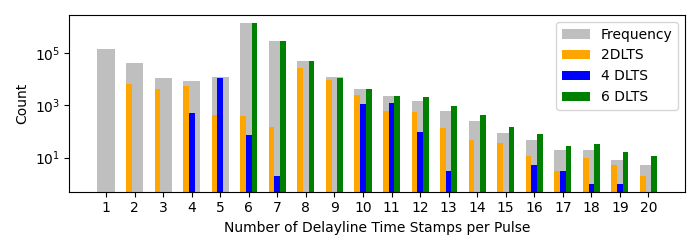

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to count occurrences
channel_lengths = {i: 0 for i in range(1, 500)}
channel_lengths_invalid = {i: 0 for i in range(1, 500)}
channel_lengths_event_valid_6dld = {i: 0 for i in range(1, 500)}
channel_lengths_event_valid_4dld = {i: 0 for i in range(1, 500)}
channel_lengths_event_valid_2dld = {i: 0 for i in range(1, 500)}

def length_count(events):
    for event in events:
        ch1 = 0
        ch2 = 0
        ch3 = 0
        ch4 = 0
        ch5 = 0
        ch6 = 0
        
        for ch in event['channels']:
            channel_num = ch['channel']
            num_values = ch['num_values']
            
            if channel_num == 1:
                ch1 = num_values
            elif channel_num == 2:
                ch2 = num_values
            elif channel_num == 3:
                ch3 = num_values
            elif channel_num == 4:
                ch4 = num_values
            elif channel_num == 5:
                ch5 = num_values
            elif channel_num == 6:
                ch6 = num_values

        total_values = ch1 + ch2 + ch3 + ch4 + ch5 + ch6
        dlts_value = []
        
        if total_values == 1:
            channel_lengths_invalid[total_values] += 1
        elif total_values == 2:
            if (ch1 == 1 and ch2 == 1) or (ch3 == 1 and ch4 == 1) or (ch5 == 1 and ch6 == 1):
                channel_lengths_event_valid_2dld[total_values] += 1
                dlts_value.append(2)
            else:
                channel_lengths_invalid[total_values] += 1
        elif total_values == 3:
            if (ch1 == 1 and ch2 == 1) or (ch3 == 1 and ch4 == 1) or (ch5 == 1 and ch6 == 1):
                channel_lengths_event_valid_2dld[total_values] += 1
                dlts_value.append(2)
            else:
                channel_lengths_invalid[total_values] += 1
        elif total_values == 4:
            if ((ch1 == 1 and ch2 == 1) and (ch3 == 1 and ch4 == 1)) or ((ch1 == 1 and ch2 == 1) and (ch5 == 1 and ch6 == 1)) or ((ch3 == 1 and ch4 == 1) and (ch5 == 1 and ch6 == 1)):
                channel_lengths_event_valid_4dld[total_values] += 1
                dlts_value.append(4)
            elif (ch1 == 1 and ch2 == 1) or (ch3 == 1 and ch4 == 1) or (ch5 == 1 and ch6 == 1):
                channel_lengths_event_valid_2dld[total_values] += 1
                dlts_value.append(2)
            else:
                channel_lengths_invalid[total_values] += 1
        elif total_values == 5:
            if ((ch1 == 1 and ch2 == 1) and (ch3 == 1 and ch4 == 1)) or ((ch1 == 1 and ch2 == 1) and (ch5 == 1 and ch6 == 1)) or ((ch3 == 1 and ch4 == 1) and (ch5 == 1 and ch6 == 1)):
                channel_lengths_event_valid_4dld[total_values] += 1
                dlts_value.append(4)
            elif (ch1 == 1 and ch2 == 1) or (ch3 == 1 and ch4 == 1) or (ch5 == 1 and ch6 == 1):
                channel_lengths_event_valid_2dld[total_values] += 1
                dlts_value.append(2)
            else:
                channel_lengths_invalid[total_values] += 1
        elif total_values == 6:
            if ch1 == 1 and ch2 == 1 and ch3 == 1 and ch4 == 1 and ch5 == 1 and ch6 == 1:
                channel_lengths_event_valid_6dld[total_values] += 1
                dlts_value.append(6)
            elif ((ch1 == 1 and ch2 == 1) and (ch3 == 1 and ch4 == 1)) or ((ch1 == 1 and ch2 == 1) and (ch5 == 1 and ch6 == 1)) or ((ch3 == 1 and ch4 == 1) and (ch5 == 1 and ch6 == 1)):
                channel_lengths_event_valid_4dld[total_values] += 1
                dlts_value.append(4)
            elif (ch1 == 1 and ch2 == 1) or (ch3 == 1 and ch4 == 1) or (ch5 == 1 and ch6 == 1):
                channel_lengths_event_valid_2dld[total_values] += 1
                dlts_value.append(2)
            else:
                channel_lengths_invalid[total_values] += 1
        elif 7 <= total_values <= 11:
            if ch1 >= 1 and ch2 >= 1 and ch3 >= 1 and ch4 >= 1 and ch5 >= 1 and ch6 >= 1:
                channel_lengths_event_valid_6dld[total_values] += 1
                dlts_value.append(6)
                ch1 -= 1
                ch2 -= 1
                ch3 -= 1
                ch4 -= 1
                ch5 -= 1
                ch6 -= 1
            if ((ch1 == 1 and ch2 == 1) and (ch3 == 1 and ch4 == 1)) or ((ch1 == 1 and ch2 == 1) and (ch5 == 1 and ch6 == 1)) or ((ch3 == 1 and ch4 == 1) and (ch5 == 1 and ch6 == 1)):
                channel_lengths_event_valid_4dld[total_values] += 1
                dlts_value.append(4)
            elif (ch1 == 1 and ch2 == 1) or (ch3 == 1 and ch4 == 1) or (ch5 == 1 and ch6 == 1):
                channel_lengths_event_valid_2dld[total_values] += 1
                dlts_value.append(2)
            else:
                channel_lengths_invalid[total_values] += 1
        elif 12 <= total_values <= 17:
            if ch1 >= 1 and ch2 >= 1 and ch3 >= 1 and ch4 >= 1 and ch5 >= 1 and ch6 >= 1:
                channel_lengths_event_valid_6dld[total_values] += 1
                dlts_value.append(6)
                ch1 -= 1
                ch2 -= 1
                ch3 -= 1
                ch4 -= 1
                ch5 -= 1
                ch6 -= 1
            if ch1 >= 1 and ch2 >= 1 and ch3 >= 1 and ch4 >= 1 and ch5 >= 1 and ch6 >= 1:
                channel_lengths_event_valid_6dld[total_values] += 1
                dlts_value.append(6)
                ch1 -= 1
                ch2 -= 1
                ch3 -= 1
                ch4 -= 1
                ch5 -= 1
                ch6 -= 1
            if ((ch1 == 1 and ch2 == 1) and (ch3 == 1 and ch4 == 1)) or ((ch1 == 1 and ch2 == 1) and (ch5 == 1 and ch6 == 1)) or ((ch3 == 1 and ch4 == 1) and (ch5 == 1 and ch6 == 1)):
                channel_lengths_event_valid_4dld[total_values] += 1
                dlts_value.append(4)
            elif (ch1 == 1 and ch2 == 1) or (ch3 == 1 and ch4 == 1) or (ch5 == 1 and ch6 == 1):
                channel_lengths_event_valid_2dld[total_values] += 1
                dlts_value.append(2)
            else:
                channel_lengths_invalid[total_values] += 1
        elif 18 <= total_values <= 20:
            if ch1 >= 1 and ch2 >= 1 and ch3 >= 1 and ch4 >= 1 and ch5 >= 1 and ch6 >= 1:
                channel_lengths_event_valid_6dld[total_values] += 1
                dlts_value.append(6)
                ch1 -= 1
                ch2 -= 1
                ch3 -= 1
                ch4 -= 1
                ch5 -= 1
                ch6 -= 1
            if ch1 >= 1 and ch2 >= 1 and ch3 >= 1 and ch4 >= 1 and ch5 >= 1 and ch6 >= 1:
                channel_lengths_event_valid_6dld[total_values] += 1
                dlts_value.append(6)
                ch1 -= 1
                ch2 -= 1
                ch3 -= 1
                ch4 -= 1
                ch5 -= 1
                ch6 -= 1
            if ch1 >= 1 and ch2 >= 1 and ch3 >= 1 and ch4 >= 1 and ch5 >= 1 and ch6 >= 1:
                channel_lengths_event_valid_6dld[total_values] += 1
                dlts_value.append(6)
                ch1 -= 1
                ch2 -= 1
                ch3 -= 1
                ch4 -= 1
                ch5 -= 1
                ch6 -= 1
            if ((ch1 == 1 and ch2 == 1) and (ch3 == 1 and ch4 == 1)) or ((ch1 == 1 and ch2 == 1) and (ch5 == 1 and ch6 == 1)) or ((ch3 == 1 and ch4 == 1) and (ch5 == 1 and ch6 == 1)):
                channel_lengths_event_valid_4dld[total_values] += 1
                dlts_value.append(4)
            elif (ch1 == 1 and ch2 == 1) or (ch3 == 1 and ch4 == 1) or (ch5 == 1 and ch6 == 1):
                channel_lengths_event_valid_2dld[total_values] += 1
                dlts_value.append(2)
            else:
                channel_lengths_invalid[total_values] += 1

        if total_values != 0:
            channel_lengths[total_values] += 1
        
        # Add dlts_value to the event
        event['dlts'] = dlts_value

    return events

# Example usage:
events_dlts = length_count(events)

# Plotting
bins = np.arange(1, 500)

channel_lengths_arr = np.array(list(channel_lengths.values()))
channel_lengths_event_valid_arr_2dld = np.array(list(channel_lengths_event_valid_2dld.values()))
channel_lengths_invalid_arr_4dld = np.array(list(channel_lengths_event_valid_4dld.values()))
channel_lengths_event_valid_arr_6dld = np.array(list(channel_lengths_event_valid_6dld.values()))

index = 20  # Limiting to first 20 bins for better visualization
channel_lengths_arr = channel_lengths_arr[:index]
channel_lengths_event_valid_arr_6dld = channel_lengths_event_valid_arr_6dld[:index]
channel_lengths_event_valid_arr_2dld = channel_lengths_event_valid_arr_2dld[:index]
channel_lengths_invalid_arr_4dld = channel_lengths_invalid_arr_4dld[:index]

# Define the width of the bars
width = 0.2
fig, ax = plt.subplots(figsize=(7,2.5))
# Plot bar charts for all arrays
plt.bar(bins[:index], channel_lengths_arr, width=width*3, label='Frequency', alpha=0.5, color='gray')
plt.bar(bins[:index] - width, channel_lengths_event_valid_arr_2dld, width=width, label='2DLTS', color='orange')
plt.bar(bins[:index], channel_lengths_invalid_arr_4dld, width=width, label='4 DLTS', color='blue')
plt.bar(bins[:index] + width, channel_lengths_event_valid_arr_6dld, width=width, label='6 DLTS', color='green')



ax.set_xlabel('Number of Delayline Time Stamps per Pulse', fontsize=10)
plt.xticks(bins[:index], [str(i) for i in range(1, index+1)])
ax.set_ylabel('Count', fontsize=10)
ax.set_yscale('log')
plt.legend(loc='upper right')
plt.tight_layout()
from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'
plt.savefig("raw_stat_roetdek.svg", format="svg", dpi=600)
plt.savefig("raw_stat_roetdek.png", format="png", dpi=600)
plt.show()

In [18]:
events_dlts[0]

{'event_number': 1,
 'channels': [{'channel': 1, 'num_values': 1, 'values': [1081.0]},
  {'channel': 2, 'num_values': 1, 'values': [3522.0]},
  {'channel': 3, 'num_values': 1, 'values': [2448.0]},
  {'channel': 4, 'num_values': 1, 'values': [2083.0]},
  {'channel': 5, 'num_values': 1, 'values': [857.0]},
  {'channel': 6, 'num_values': 1, 'values': [3695.0]},
  {'channel': 8, 'num_values': 1, 'values': [0.0]}],
 'T': 0.0,
 'dT': 0.0,
 'dlts': [6]}

In [19]:
# New list to store filtered events
filtered_events = []

for i, event in enumerate(events_dlts):
    # Extract the relevant positions from the data array
    data_row = data[i]
    detx_positions = [6, 10, 14, 18]
    dety_positions = [7, 11, 15, 19]
    t_positions = [8, 12, 16, 20]
    
    # Check if positions 6, 7, and 8 are all zero
    if data_row[6] == 0 and data_row[7] == 0 and data_row[8] == 0:
        continue  # Skip this event

    # Initialize lists for the new categories
    detx = []
    dety = []
    t = []

    # Populate the lists while checking if the t_positions are non-zero
    for dx_pos, dy_pos, t_pos in zip(detx_positions, dety_positions, t_positions):
        if data_row[t_pos] != 0:
            detx.append(data_row[dx_pos])
            dety.append(data_row[dy_pos])
            t.append(data_row[t_pos])

    # Add new categories to the event if there are valid entries
    if t:  # Ensure that t is not empty
        event['detx'] = detx
        event['dety'] = dety
        event['t'] = t

        # Add the event to the filtered list
        filtered_events.append(event)
        
print(len(data), len(filtered_events))

2328872 1636401


In [32]:
filtered_events[0]

{'event_number': 3,
 'channels': [{'channel': 1, 'num_values': 1, 'values': [3381.0]},
  {'channel': 2, 'num_values': 1, 'values': [1170.0]},
  {'channel': 3, 'num_values': 1, 'values': [2332.0]},
  {'channel': 4, 'num_values': 1, 'values': [2203.0]},
  {'channel': 5, 'num_values': 1, 'values': [3363.0]},
  {'channel': 6, 'num_values': 1, 'values': [1290.0]},
  {'channel': 7, 'num_values': 1, 'values': [-39336.0]},
  {'channel': 8, 'num_values': 1, 'values': [0.0]}],
 'T': 30452695.957,
 'dT': 29775944.998,
 'dlts': [6],
 'detx': [23.0755],
 'dety': [13.7877],
 't': [987.9956]}

In [34]:
t_2dlts = []
t_4dlts = []
t_6dlts = []
for i, event in enumerate(filtered_events):
    dlts_event = event['dlts']
    # if len(dlts_event) > 1:
    #     print(dlts_event)
    try:
        for j in range(len(dlts_event)):
            if dlts_event[j] == 2:
                t_2dlts.append(event['t'][j])
            elif dlts_event[j] == 4:
                t_4dlts.append(event['t'][j])
            elif dlts_event[j] == 6:
                t_6dlts.append(event['t'][j])
    except:
        pass
print(len(t_2dlts), len(t_4dlts), len(t_6dlts))

# Calculate the total length of all lists combined
total_length = len(t_2dlts) + len(t_4dlts) + len(t_6dlts)

# Calculate and print the percentage of each list
if total_length > 0:
    percentage_2dlts = (len(t_2dlts) / total_length) * 100
    percentage_4dlts = (len(t_4dlts) / total_length) * 100
    percentage_6dlts = (len(t_6dlts) / total_length) * 100

    print(f"Percentage of t_2dlts: {percentage_2dlts:.2f}%")
    print(f"Percentage of t_4dlts: {percentage_4dlts:.2f}%")
    print(f"Percentage of t_6dlts: {percentage_6dlts:.2f}%")
else:
    print("No events found.")

11679 10731 1621256
Percentage of t_2dlts: 0.71%
Percentage of t_4dlts: 0.65%
Percentage of t_6dlts: 98.64%


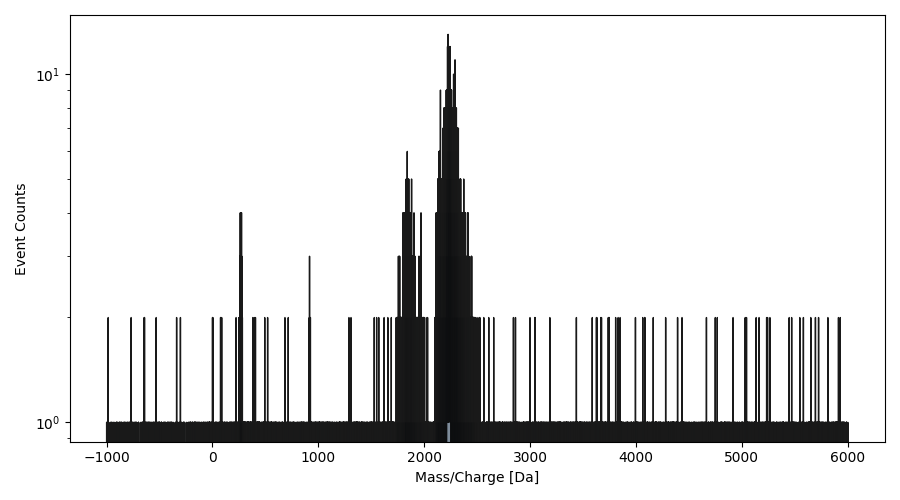

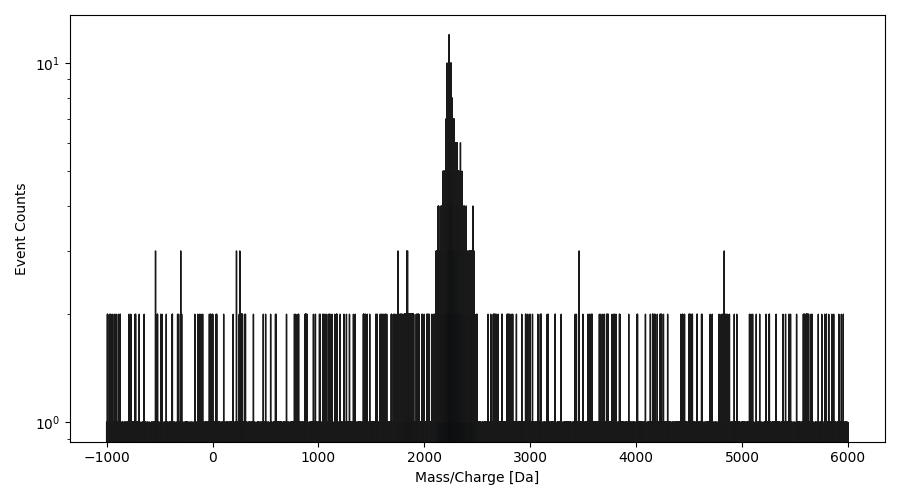

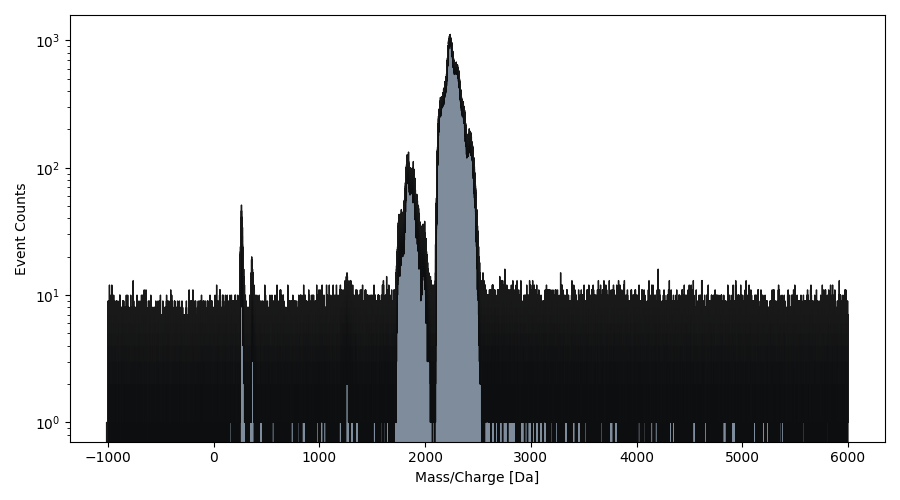

In [39]:
t_2dlts = np.array(t_2dlts)
tof_plot = AptHistPlotter(t_2dlts[t_2dlts<10000])
y_hist, x_hist = tof_plot.plot_histogram()

t_4dlts = np.array(t_4dlts)
tof_plot = AptHistPlotter(t_4dlts[t_4dlts<10000])
y_hist, x_hist = tof_plot.plot_histogram()

t_6dlts = np.array(t_6dlts)
tof_plot = AptHistPlotter(t_6dlts[t_6dlts<10000])
y_hist, x_hist = tof_plot.plot_histogram()

In [41]:
# Define masks for t_2dlts
mask_h_t_2dlts = (t_2dlts > 245) & (t_2dlts < 285)
mask_al_2plus_t_2dlts = (t_2dlts > 1726) & (t_2dlts < 1932)
mask_al_1plus_t_2dlts = (t_2dlts > 2090) & (t_2dlts < 2486)

# Define masks for t_4dlts
mask_h_t_4dlts = (t_4dlts > 215) & (t_4dlts < 264)
mask_al_2plus_t_4dlts = (t_4dlts > 1693) & (t_4dlts < 1872)
mask_al_1plus_t_4dlts = (t_4dlts > 2061) & (t_4dlts < 2505)

# Define masks for t_6dlts
mask_h_t_6dlts = (t_6dlts > 242) & (t_6dlts < 293)
mask_al_2plus_t_6dlts = (t_6dlts > 1715) & (t_6dlts < 2042)
mask_al_1plus_t_6dlts = (t_6dlts > 2081) & (t_6dlts < 2526)

# Count the number of True values in each mask for t_2dlts
num_true_h_t_2dlts = np.sum(mask_h_t_2dlts)
num_true_al_2plus_t_2dlts = np.sum(mask_al_2plus_t_2dlts)
num_true_al_1plus_t_2dlts = np.sum(mask_al_1plus_t_2dlts)

# Calculate the total number of True values across all masks for t_2dlts
total_trues_t_2dlts = num_true_h_t_2dlts + num_true_al_2plus_t_2dlts + num_true_al_1plus_t_2dlts

# Count the number of True values in each mask for t_4dlts
num_true_h_t_4dlts = np.sum(mask_h_t_4dlts)
num_true_al_2plus_t_4dlts = np.sum(mask_al_2plus_t_4dlts)
num_true_al_1plus_t_4dlts = np.sum(mask_al_1plus_t_4dlts)

# Calculate the total number of True values across all masks for t_4dlts
total_trues_t_4dlts = num_true_h_t_4dlts + num_true_al_2plus_t_4dlts + num_true_al_1plus_t_4dlts

# Count the number of True values in each mask for t_6dlts
num_true_h_t_6dlts = np.sum(mask_h_t_6dlts)
num_true_al_2plus_t_6dlts = np.sum(mask_al_2plus_t_6dlts)
num_true_al_1plus_t_6dlts = np.sum(mask_al_1plus_t_6dlts)

# Calculate the total number of True values across all masks for t_6dlts
total_trues_t_6dlts = num_true_h_t_6dlts + num_true_al_2plus_t_6dlts + num_true_al_1plus_t_6dlts

# Calculate the grand total of True values across all datasets
grand_total_trues = total_trues_t_2dlts + total_trues_t_4dlts + total_trues_t_6dlts

# Calculate the percentage of True values for each mask in t_2dlts
percentage_h_t_2dlts = (num_true_h_t_2dlts / grand_total_trues) * 100 if grand_total_trues > 0 else 0
percentage_al_2plus_t_2dlts = (num_true_al_2plus_t_2dlts / grand_total_trues) * 100 if grand_total_trues > 0 else 0
percentage_al_1plus_t_2dlts = (num_true_al_1plus_t_2dlts / grand_total_trues) * 100 if grand_total_trues > 0 else 0

# Print the results for t_2dlts
print(f"Number of True values in mask_h_t_2dlts: {num_true_h_t_2dlts}")
print(f"Number of True values in mask_al_2plus_t_2dlts: {num_true_al_2plus_t_2dlts}")
print(f"Number of True values in mask_al_1plus_t_2dlts: {num_true_al_1plus_t_2dlts}")

print(f"Percentage of True values in mask_h_t_2dlts: {percentage_h_t_2dlts:.2f}%")
print(f"Percentage of True values in mask_al_2plus_t_2dlts: {percentage_al_2plus_t_2dlts:.2f}%")
print(f"Percentage of True values in mask_al_1plus_t_2dlts: {percentage_al_1plus_t_2dlts:.2f}%")

# Calculate the percentage of True values for each mask in t_4dlts
percentage_h_t_4dlts = (num_true_h_t_4dlts / grand_total_trues) * 100 if grand_total_trues > 0 else 0
percentage_al_2plus_t_4dlts = (num_true_al_2plus_t_4dlts / grand_total_trues) * 100 if grand_total_trues > 0 else 0
percentage_al_1plus_t_4dlts = (num_true_al_1plus_t_4dlts / grand_total_trues) * 100 if grand_total_trues > 0 else 0

# Print the results for t_4dlts
print(f"Number of True values in mask_h_t_4dlts: {num_true_h_t_4dlts}")
print(f"Number of True values in mask_al_2plus_t_4dlts: {num_true_al_2plus_t_4dlts}")
print(f"Number of True values in mask_al_1plus_t_4dlts: {num_true_al_1plus_t_4dlts}")

print(f"Percentage of True values in mask_h_t_4dlts: {percentage_h_t_4dlts:.2f}%")
print(f"Percentage of True values in mask_al_2plus_t_4dlts: {percentage_al_2plus_t_4dlts:.2f}%")
print(f"Percentage of True values in mask_al_1plus_t_4dlts: {percentage_al_1plus_t_4dlts:.2f}%")

# Calculate the percentage of True values for each mask in t_6dlts
percentage_h_t_6dlts = (num_true_h_t_6dlts / grand_total_trues) * 100 if grand_total_trues > 0 else 0
percentage_al_2plus_t_6dlts = (num_true_al_2plus_t_6dlts / grand_total_trues) * 100 if grand_total_trues > 0 else 0
percentage_al_1plus_t_6dlts = (num_true_al_1plus_t_6dlts / grand_total_trues) * 100 if grand_total_trues > 0 else 0

# Print the results for t_6dlts
print(f"Number of True values in mask_h_t_6dlts: {num_true_h_t_6dlts}")
print(f"Number of True values in mask_al_2plus_t_6dlts: {num_true_al_2plus_t_6dlts}")
print(f"Number of True values in mask_al_1plus_t_6dlts: {num_true_al_1plus_t_6dlts}")

print(f"Percentage of True values in mask_h_t_6dlts: {percentage_h_t_6dlts:.2f}%")
print(f"Percentage of True values in mask_al_2plus_t_6dlts: {percentage_al_2plus_t_6dlts:.2f}%")
print(f"Percentage of True values in mask_al_1plus_t_6dlts: {percentage_al_1plus_t_6dlts:.2f}%")


Number of True values in mask_h_t_2dlts: 217
Number of True values in mask_al_2plus_t_2dlts: 1300
Number of True values in mask_al_1plus_t_2dlts: 6963
Percentage of True values in mask_h_t_2dlts: 0.02%
Percentage of True values in mask_al_2plus_t_2dlts: 0.09%
Percentage of True values in mask_al_1plus_t_2dlts: 0.49%
Number of True values in mask_h_t_4dlts: 74
Number of True values in mask_al_2plus_t_4dlts: 367
Number of True values in mask_al_1plus_t_4dlts: 4606
Percentage of True values in mask_h_t_4dlts: 0.01%
Percentage of True values in mask_al_2plus_t_4dlts: 0.03%
Percentage of True values in mask_al_1plus_t_4dlts: 0.33%
Number of True values in mask_h_t_6dlts: 6364
Number of True values in mask_al_2plus_t_6dlts: 116434
Number of True values in mask_al_1plus_t_6dlts: 1275156
Percentage of True values in mask_h_t_6dlts: 0.45%
Percentage of True values in mask_al_2plus_t_6dlts: 8.25%
Percentage of True values in mask_al_1plus_t_6dlts: 90.34%
